In [52]:
import numpy as np
import pandas as pd
import scanpy as sc

In [53]:
from matplotlib.pyplot import hist

In [54]:
import gc

In [55]:
import spatialdm as sdm
import spatialdm.plottings as pl

In [56]:
import squidpy as sq

In [57]:
# load the pre-processed dataset
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()

In [58]:
# sq.gr.spatial_neighbors(adata)
# sq.gr.nhood_enrichment(adata, cluster_key="cluster")
# sq.pl.nhood_enrichment(adata, cluster_key="cluster")

Set up

In [59]:
## SpatialDM tutorial data
# adata = sdm.datasets.melanoma()
# raw = pd.DataFrame(adata.raw.X, index=adata.obs_names, columns=adata.raw.var_names)
# log = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)

In [60]:
# raw = pd.DataFrame(adata.raw.X.todense(), index=adata.obs_names, columns=adata.raw.var_names)
log = pd.DataFrame(adata.X.todense(), index=adata.obs_names, columns=adata.var_names)
raw = log

In [61]:
spatialcoord = pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names, columns=['x','y'])

In [62]:
# Preprocessing
my_sample = sdm.SpatialDM(log, raw, spatialcoord)     # load spatial data with simply log, raw, spatial input

In [63]:
my_sample.extract_lr(species='mouse', min_cell=3)

We set radial basis kernel parameter l = 1.2, and trimmed all weights < 0.2 (cutoff) to match the normal range of CCC (200 micrometers, 1 spot away from the sender cell here)

In [64]:
?my_sample.weight_matrix

Signature:
my_sample.weight_matrix(
    l,
    cutoff=None,
    n_neighbors=None,
    single_cell=False,
)
Docstring:
compute weight matrix based on radial basis kernel.
cutoff & n_neighbors are two alternative options to         make the matrix sparse
:param l: radial basis kernel parameter, need to be customized to restrain the range of signaling
 before downstream processing.
:param cutoff: minimum weight to be kept from the rbf weight matrix. Weight below cutoff will be made zero
:param n_neighbors: number of neighbors per spot from the rbf weight matrix.
Non-neighbors will be made 0
:param single_cell: if single cell resolution, diagonal will be made 0.
:return: rbf_d weight matrix in obj attribute
File:      ~/anaconda3/lib/python3.8/site-packages/spatialdm/main.py
Type:      method


In [65]:
my_sample.weight_matrix(l=100, cutoff=0.2, single_cell=False)  # Not single-cell resolution

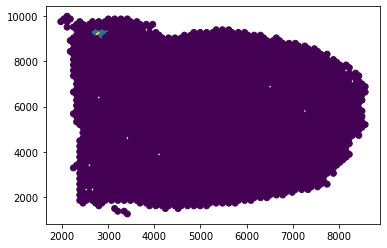

In [66]:
import matplotlib.pyplot as plt
plt.scatter(my_sample.spatialcoord.x, my_sample.spatialcoord.y, c=my_sample.rbf_d[50])

Global Moran's I

In [67]:
%%time
# Global selection of significant pairs
my_sample.spatialdm_global(1000, method='both', select_num=None)  # complete in seconds
my_sample.sig_pairs(method='permutation', fdr=True, threshold=0.1)  # select significant pairs

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f16bd1e3a60>
Traceback (most recent call last):
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
100%|██████████| 1000/1000 [01:02<00:00, 16.10it/s]

CPU times: user 1min 2s, sys: 62.2 ms, total: 1min 2s
Wall time: 1min 2s


Moran's global I per LR across the slide

In [68]:
res = my_sample.global_res

In [69]:
res['global_I'] = my_sample.global_I

In [70]:
res

,ligand,receptor,z_pval,perm_pval,fdr,selected,global_I
TGFB1_TGFBR1_TGFBR2,[Tgfb1],"[Tgfbr1, Tgfbr2]",1.685912e-04,0.000,0.000000,True,0.030023
TGFB2_TGFBR1_TGFBR2,[Tgfb2],"[Tgfbr1, Tgfbr2]",1.668284e-05,0.000,0.000000,True,0.034748
TGFB3_TGFBR1_TGFBR2,[Tgfb3],"[Tgfbr1, Tgfbr2]",9.393182e-03,0.010,0.033267,True,0.019678
TGFB1_ACVR1B_TGFBR2,[Tgfb1],"[Acvr1b, Tgfbr2]",4.893189e-01,0.487,0.773350,False,0.000224
TGFB1_ACVR1C_TGFBR2,[Tgfb1],"[Acvr1c, Tgfbr2]",5.432353e-02,0.095,0.233168,False,0.013436
...,...,...,...,...,...,...,...
THY1_ITGAV_ITGB3,[Thy1],"[Itgav, Itgb3]",4.881027e-05,0.000,0.000000,True,0.032632
ITGA4_ITGB1_VCAM1,"[Itga4, Itgb1]",[Vcam1],3.489889e-12,0.000,0.000000,True,0.057435
ITGA9_ITGB1_VCAM1,"[Itga9, Itgb1]",[Vcam1],3.531991e-15,0.000,0.000000,True,0.065183
ITGA4_ITGB7_VCAM1,"[Itga4, Itgb7]",[Vcam1],1.809730e-01,0.223,0.441604,False,0.007635


In [71]:
res[res.index.str.contains('SEMA4D_PLXNB3')][res.global_I > 0.3].sort_values(by='global_I')

<ipython-input-71-384c796ce143>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,ligand,receptor,z_pval,perm_pval,fdr,selected,global_I
SEMA4D_PLXNB3,[Sema4d],[Plxnb3],1.360399e-303,0.0,0.0,True,0.311747


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


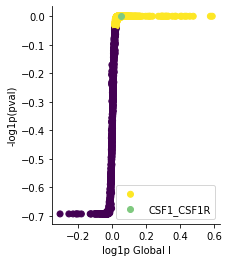

In [72]:
pl.global_plot(my_sample, pairs=['CSF1_CSF1R'])  # Overview of global selection

Local Moran's I

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f16bd18b160>
Traceback (most recent call last):
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
100%|██████████| 100/100 [00:02<00:00, 33.45it/s]


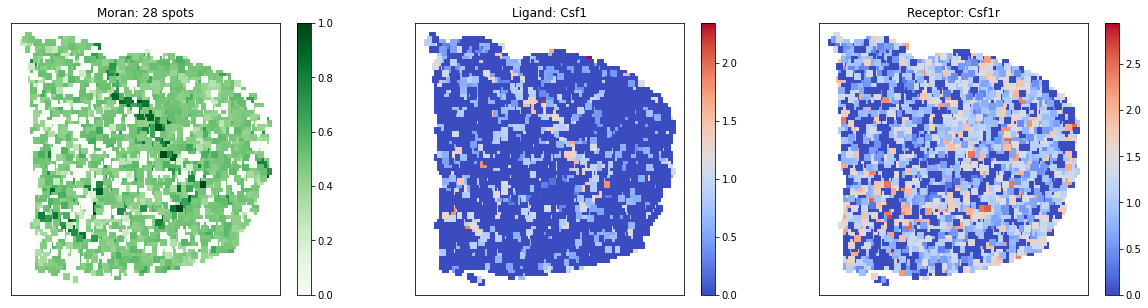

In [73]:
# Local selection of significant spots
my_sample.spatialdm_local(n_perm=100, method='both', select_num=None, nproc=1)     # local spot selection complete in seconds
my_sample.sig_spots(threshold=0.1)  # significant local spots
pl.plot_pairs(my_sample, ['CSF1_CSF1R'], marker='s') # visualize known melanoma pair(s)

Re-implement Moran's Global I

1. DataFrame /w L & R 
2. Calulcate L & R means & props (accounting for complexes)
3. Re-implement radial kernel weight
4. Moran's R
5. p-val /w Permutations
6. z-score pvals

In [74]:
adata

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [75]:
from liana.method._pipe_utils._pre import prep_check_adata
from liana.resource import select_resource, explode_complexes
from threadpoolctl import threadpool_limits

In [76]:
from liana.method._pipe_utils import prep_check_adata, filter_resource

In [77]:
from liana.method._liana_pipe import filter_reassemble_complexes

In [78]:
_key_cols = ['ligand_complex', 'receptor_complex']

In [79]:
adata = prep_check_adata(adata, groupby='cluster', keep_obsm=True, min_cells=3)

In [80]:
resource = select_resource('MouseConsensus')

In [81]:
adata.var_names

Index(['0610005C13Rik', '0610009B22Rik', '0610009O20Rik', '0610010F05Rik',
       '0610010K14Rik', '0610012G03Rik', '0610025J13Rik', '0610030E20Rik',
       '0610033M10Rik', '0610037L13Rik',
       ...
       'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4',
       'mt-Nd4l', 'mt-Nd5', 'mt-Nd6'],
      dtype='object', length=18078)

In [82]:
adata.obsm

AxisArrays with keys: X_pca, X_umap, spatial

In [83]:
# # fix this later
# temp = sq.datasets.visium_hne_adata()
# # adata.layers['counts'] = temp.raw.X THIS IS JUST BAD!!
# del temp
# gc.collect()

Process Resource

In [84]:
resource = explode_complexes(resource)

In [85]:
resource = filter_resource(resource, adata.var_names)

In [86]:
resource

,interaction,ligand,receptor,ligand_complex,receptor_complex
0,Dll1|Notch1,Dll1,Notch1,Dll1,Notch1
1,Dll1|Notch2,Dll1,Notch2,Dll1,Notch2
2,Dll1|Notch4,Dll1,Notch4,Dll1,Notch4
3,Dll1|Notch3,Dll1,Notch3,Dll1,Notch3
4,Nrg2|Erbb2_Erbb3,Nrg2,Erbb2,Nrg2,Erbb2_Erbb3
...,...,...,...,...,...
5070,Saa2|Grm7,Saa2,Grm7,Saa2,Grm7
5073,Saa1|Scarb1,Saa1,Scarb1,Saa1,Scarb1
5074,Saa2|Scarb1,Saa2,Scarb1,Saa2,Scarb1
5075,Saa1|Tlr2,Saa1,Tlr2,Saa1,Tlr2


Get slide means

In [87]:
entities = np.union1d(np.unique(resource["ligand"]),
                      np.unique(resource["receptor"]))

In [88]:
# Filter to only include the relevant genes
adata = adata[:, np.intersect1d(entities, adata.var.index)]

In [89]:
lr_stats = pd.DataFrame({'means': adata.X.mean(axis=0).A.flatten(), 
                        'props': adata.X.getnnz(axis=0) / adata.X.shape[0]},
                        index=adata.var_names).reset_index().rename(columns={'index': 'gene'})

In [90]:
def _rename_means(lr_stats, entity):
    df = lr_stats.copy()
    df.columns = df.columns.map(lambda x: entity + '_' + str(x) if x!='gene' else 'gene')
    return df.rename(columns = {'gene':entity})

In [91]:
lr_res = resource.merge(_rename_means(lr_stats, entity='ligand')).merge(_rename_means(lr_stats, entity='receptor'))

In [92]:
# # Filter non-expressed
# lr_res = lr_res[(lr_res.ligand_props > 0.05) & (lr_res.receptor_props > 0.05)]

Recomplexify

In [93]:
lr_res = filter_reassemble_complexes(lr_res=lr_res,
                                       _key_cols=_key_cols,
                                       expr_prop=0.05,
                                       complex_cols=['ligand_means', 'receptor_means'])

In [94]:
lr_res[lr_res.interaction.str.contains('Plxnb3')]

,interaction,ligand,receptor,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min
1221,Sema5a|Plxnb3,Sema5a,Plxnb3,Sema5a,Plxnb3,0.418452,0.452009,0.190867,0.219866,0.219866
1222,Sema4d|Plxnb3,Sema4d,Plxnb3,Sema4d,Plxnb3,0.544131,0.524554,0.190867,0.219866,0.219866
1223,Sema4a|Plxnb3,Sema4a,Plxnb3,Sema4a,Plxnb3,0.296781,0.383557,0.190867,0.219866,0.219866


For now I will use their spatial kernel weights

In [95]:
rbf_d = my_sample.rbf_d

In [96]:
# every spot to every spot:
my_sample.rbf_d.shape[0]

2688

(Vectorized) For all interactions:

norm expr mat - i.e. (x - x^) & (y - y^)

In [97]:
norm_mat = np.array(adata.X - np.array(adata.X.mean(axis=0)))
sqrt_a = np.sqrt(np.sum(np.power(norm_mat, 2), axis=0)).T

In [98]:
ligand_pos = {entity: np.where(adata.var_names == entity)[0][0] for entity
              in lr_res['ligand']}
receptor_pos = {entity: np.where(adata.var_names == entity)[0][0] for entity
                in lr_res['receptor']}

Calculate Global Moran's R

In [99]:
import scipy
from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF

In [100]:
# essential for this to be sparse
dist = scipy.sparse.csr_matrix(my_sample.rbf_d)

In [101]:
norm_mat = np.array(adata.X - np.array(adata.X.mean(axis=0))) # normalized x matrix

In [102]:
norm_mat = norm_mat / np.sqrt(np.sum(norm_mat**2, axis=0, keepdims=True))

In [103]:
# sqrt_a = np.sqrt(np.sum(np.power(norm_mat, 2), axis=0)).T # sqrt matrix
# positions
ligand_pos = {entity: np.where(adata.var_names == entity)[0][0] for entity
              in lr_res['ligand']}
receptor_pos = {entity: np.where(adata.var_names == entity)[0][0] for entity
                in lr_res['receptor']}

In [104]:
n_perm = 1000

In [105]:
ligand_mat = np.array([norm_mat[:, ligand_pos[ligand]] for ligand in lr_res.ligand])
receptor_mat = np.array([norm_mat[:, receptor_pos[receptor]] for receptor in lr_res.receptor])
# ligand_sqrt = np.array([sqrt_a[ligand_pos[ligand]] for ligand in lr_res.ligand])
# receptor_sqrt = np.array([sqrt_a[receptor_pos[receptor]] for receptor in lr_res.receptor])

global_r for all

In [106]:
global_r = ((ligand_mat @ dist)* receptor_mat).sum(axis=1)

In [107]:
lr_res['global_r'] = global_r

Create a perm_matrix for all LRs

Permutation p-vals

In [108]:
rng = np.random.default_rng()

In [109]:
idx = norm_mat.shape[0]

In [110]:
# mat /w n_perms x LR_n
perm_mat = np.zeros((n_perm, global_r.shape[0]))

In [111]:
%%time
for perm in tqdm(range(n_perm)):
    _idx = rng.permutation(idx)
    perm_mat[perm,:] = ((ligand_mat[:, _idx] @ dist) * receptor_mat).sum(axis=1)

100%|██████████| 1000/1000 [00:32<00:00, 30.68it/s]

CPU times: user 32.7 s, sys: 42.4 ms, total: 32.7 s
Wall time: 32.6 s


In [112]:
global_pvals = 1 - (global_r > perm_mat).sum(axis=0)/n_perm

In [113]:
lr_res['global_pvals'] = global_pvals

Z-score p-vals

In [114]:
from scipy import stats

In [115]:
dist = np.array(dist.todense())

In [116]:
# global distance variance (~copy pasted)
n = adata.shape[0]
nm = (n ** 2 * (dist * dist).sum()) - (2 * n * (dist.sum(axis=1) * dist.sum(axis=0)).sum()) + (dist.sum() ** 2)
dm = n ** 2 * (n - 1) ** 2

In [117]:
# squered variance
dist_var = nm/dm  # aka st

In [118]:
dist_var_sq = dist_var ** (1 / 2)

In [119]:
dist_var_sq

0.00837473813175262

In [120]:
global_zscores = global_r / dist_var_sq

In [121]:
global_zpvals = stats.norm.sf(global_zscores)

In [122]:
# assign to LR
lr_res['global_zscores'] = global_zscores

In [123]:
lr_res['global_zpvals'] = global_zpvals

Compare global

In [124]:
lr_res.interaction = lr_res.interaction.str.upper()
lr_res.interaction = lr_res.interaction.str.replace('|', '_')

<ipython-input-124-b09654ff13ad>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [125]:
res = res.reset_index().rename(columns={'index':'interaction'})

In [126]:
res = res[[len(rec) < 2 for rec in res.receptor]]

In [127]:
lr_res[lr_res.interaction=="SEMA4D_PLXNB3"]

,interaction,ligand,receptor,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min,global_r,global_pvals,global_zscores,global_zpvals
1222,SEMA4D_PLXNB3,Sema4d,Plxnb3,Sema4d,Plxnb3,0.544131,0.524554,0.190867,0.219866,0.219866,0.311746,0.0,37.224617,1.364241e-303


In [128]:
res[res.interaction=="SEMA4D_PLXNB3"]

,interaction,ligand,receptor,z_pval,perm_pval,fdr,selected,global_I
1481,SEMA4D_PLXNB3,[Sema4d],[Plxnb3],1.360399e-303,0.0,0.0,True,0.311747


In [129]:
joined = lr_res.merge(res, on='interaction')

In [130]:
joined.sort_values('global_r')

,interaction,ligand_x,receptor_x,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min,...,global_pvals,global_zscores,global_zpvals,ligand_y,receptor_y,z_pval,perm_pval,fdr,selected,global_I
171,AGT_MAS1,Agt,Mas1,Agt,Mas1,1.153787,0.687128,0.136406,0.172619,0.172619,...,1.0,-31.603155,1.000000e+00,[Agt],[Mas1],1.000000e+00,1.0,1.0,False,-0.264667
87,EFNB3_EPHA4,Efnb3,Epha4,Efnb3,Epha4,1.000509,0.746652,1.053368,0.803199,0.746652,...,1.0,-26.919550,1.000000e+00,[Efnb3],[Epha4],1.000000e+00,1.0,1.0,False,-0.225444
71,EFNB3_EPHB6,Efnb3,Ephb6,Efnb3,Ephb6,1.000509,0.746652,0.556755,0.571429,0.571429,...,1.0,-24.620005,1.000000e+00,[Efnb3],[Ephb6],1.000000e+00,1.0,1.0,False,-0.206187
219,PSAP_GPR37,Psap,Gpr37,Psap,Gpr37,3.318095,0.999628,0.798705,0.622396,0.622396,...,1.0,-22.599236,1.000000e+00,[Psap],[Gpr37],1.000000e+00,1.0,1.0,False,-0.189263
220,PSAP_GPR37L1,Psap,Gpr37l1,Psap,Gpr37l1,3.318095,0.999628,1.765455,0.977307,0.977307,...,1.0,-19.868069,1.000000e+00,[Psap],[Gpr37l1],1.000000e+00,1.0,1.0,False,-0.166390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,EFNA3_EPHA4,Efna3,Epha4,Efna3,Epha4,0.569363,0.597470,1.053368,0.803199,0.597470,...,0.0,21.477688,1.258641e-102,[Efna3],[Epha4],1.259737e-102,0.0,0.0,True,0.179870
65,FGF1_FGFR2,Fgf1,Fgfr2,Fgf1,Fgfr2,0.509576,0.533110,0.460559,0.448289,0.448289,...,0.0,25.912191,2.426929e-148,[Fgf1],[Fgfr2],2.441312e-148,0.0,0.0,True,0.217006
82,EFNB3_EPHB1,Efnb3,Ephb1,Efnb3,Ephb1,1.000509,0.746652,0.332816,0.390625,0.390625,...,0.0,27.847652,5.750031e-171,[Efnb3],[Ephb1],5.718337e-171,0.0,0.0,True,0.233218
192,CCK_CCKBR,Cck,Cckbr,Cck,Cckbr,2.622576,0.947917,0.295722,0.344494,0.344494,...,0.0,31.825768,1.424687e-222,[Cck],[Cckbr],1.411138e-222,0.0,0.0,True,0.266535


In [131]:
import scipy

In [132]:
joined

,interaction,ligand_x,receptor_x,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min,...,global_pvals,global_zscores,global_zpvals,ligand_y,receptor_y,z_pval,perm_pval,fdr,selected,global_I
0,DLL1_NOTCH1,Dll1,Notch1,Dll1,Notch1,0.037283,0.057292,0.216689,0.276786,0.057292,...,0.135,1.228862,1.095617e-01,[Dll1],[Notch1],1.095618e-01,0.142,0.314697,False,0.010291
1,JAG1_NOTCH1,Jag1,Notch1,Jag1,Notch1,0.051299,0.075893,0.216689,0.276786,0.075893,...,0.606,-0.287137,6.129963e-01,[Jag1],[Notch1],6.129979e-01,0.576,0.869772,False,-0.002405
2,DLK1_NOTCH1,Dlk1,Notch1,Dlk1,Notch1,0.236641,0.213542,0.216689,0.276786,0.213542,...,0.989,-2.400463,9.918128e-01,[Dlk1],[Notch1],9.918127e-01,0.990,1.000000,False,-0.020103
3,DLL3_NOTCH1,Dll3,Notch1,Dll3,Notch1,0.108551,0.161086,0.216689,0.276786,0.161086,...,0.982,-2.322272,9.898909e-01,[Dll3],[Notch1],9.898906e-01,0.991,1.000000,False,-0.019448
4,JAG2_NOTCH1,Jag2,Notch1,Jag2,Notch1,0.273678,0.364583,0.216689,0.276786,0.276786,...,1.000,-4.523731,9.999970e-01,[Jag2],[Notch1],9.999970e-01,1.000,1.000000,False,-0.037885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,ENTPD1_ADORA1,Entpd1,Adora1,Entpd1,Adora1,0.089811,0.128720,0.846592,0.736979,0.128720,...,0.365,0.517597,3.023697e-01,[Entpd1],[Adora1],3.023686e-01,0.347,0.608730,False,0.004335
219,PSAP_GPR37,Psap,Gpr37,Psap,Gpr37,3.318095,0.999628,0.798705,0.622396,0.622396,...,1.000,-22.599236,1.000000e+00,[Psap],[Gpr37],1.000000e+00,1.000,1.000000,False,-0.189263
220,PSAP_GPR37L1,Psap,Gpr37l1,Psap,Gpr37l1,3.318095,0.999628,1.765455,0.977307,0.977307,...,1.000,-19.868069,1.000000e+00,[Psap],[Gpr37l1],1.000000e+00,1.000,1.000000,False,-0.166390
221,TAC1_TACR1,Tac1,Tacr1,Tac1,Tacr1,0.364385,0.326637,0.046681,0.070685,0.070685,...,0.000,20.172024,8.621802e-91,[Tac1],[Tacr1],8.611413e-91,0.000,0.000000,True,0.168936


In [133]:
scipy.stats.pearsonr(joined.fdr,  joined.global_pvals)

(0.9684465062861516, 2.4459712885688982e-135)

In [134]:
scipy.stats.pearsonr(joined.z_pval,  joined.global_zpvals)

(0.9999999999958277, 0.0)

### Local Moran's I

In [135]:
import scipy

In [136]:
dist = scipy.sparse.csr_matrix(my_sample.rbf_d)

In [137]:
# norm_mat = np.array(adata.X - np.array(adata.X.mean(axis=0))) # normalized x matrix
# Note here - there is no normalisation by the squares

In [138]:
norm_mat = np.array(adata.X - np.array(adata.X.mean(axis=0)))

In [139]:
ligand_mat = np.array([norm_mat[:, ligand_pos[ligand]] for ligand in lr_res.ligand]).T
receptor_mat = np.array([norm_mat[:, receptor_pos[receptor]] for receptor in lr_res.receptor]).T

In [140]:
# where at least one is positive
(np.array([-1, 0, 1, -1, 1]) > 0) | (np.array([-1, 0, 1, -1, -1]) > 0)

array([False, False,  True, False,  True])

In [141]:
# where either L or R is positive
pos_msk = ((ligand_mat > 0) + (receptor_mat > 0)).T

In [142]:
# calculate both sides for local_Rs
local_x = ligand_mat * (dist @ receptor_mat) # local_I
local_y = receptor_mat * (dist @ ligand_mat) # local_I_R

mask?

In [143]:
# also only sig on global (i.e. only positive by default)?
lr_msk = global_pvals <= 0.05

In [144]:
# he used to filter spot to spot to be positive
# i guess to exclude - to - positive correlations (does this even make sense...)

In [145]:
local_x = local_x[:, lr_msk]
local_y = local_y[:, lr_msk]
assert local_x.shape == local_y.shape

In [146]:
receptor_mat = receptor_mat[:, lr_msk]
ligand_mat = ligand_mat[:, lr_msk]

Permutations

In [147]:
spot_n = local_x.shape[0]
lr_n = local_x.shape[1]
n_perm = 25

In [148]:
perm_x = np.zeros((lr_n, n_perm, spot_n))
perm_y = np.zeros((lr_n, n_perm, spot_n))

In [149]:
for i in tqdm(range(n_perm)):
    _idx = np.random.permutation(ligand_mat.shape[0]) # TODO RNG
    perm_x[:, i,:] = ((dist @ receptor_mat[_idx, :]) * ligand_mat).T
    perm_y[:, i,:] = ((dist @ ligand_mat[_idx, :]) * receptor_mat).T


100%|██████████| 25/25 [00:00<00:00, 30.26it/s]


In [150]:
local_pvals = ((np.expand_dims(local_x.T + local_y.T, 1) <= (perm_x + perm_y)).sum(1)) / n_perm

In [151]:
local_r = local_x + local_y # actual value

In [152]:
import gc
del perm_mat, perm_x, perm_y
gc.collect() # should be called!

17408

Compare local pvals

In [153]:
# # positve to positive local only
# pos = ((ligand_mat > 0) + (receptor_mat > 0)).T # he does it on non-norm counts, and not -mu^
# pvals_msked = local_pvals
# pvals_msked[pos] = 1

In [154]:
ours = pd.DataFrame(local_pvals, index=lr_res.interaction).reset_index()

ValueError: Shape of passed values is (613, 2688), indices imply (1409, 2688)

In [ ]:
ours

In [ ]:
theirs =  my_sample.local_perm_p.reset_index().rename(columns={'index':'interaction'})

In [ ]:
theirs[theirs.interaction=="SEMA4D_PLXNB3"]

In [ ]:
ours[ours.interaction=="SEMA4D_PLXNB3"]

In [ ]:
# if both are negative, set to 1
local_pvals[~pos_msk] = 1

In [ ]:
scipy.stats.pearsonr(local_pvals[903], my_sample.local_perm_p.iloc[532,:])

In [ ]:
lr_res[lr_res.interaction=="SEMA4D_PLXNB3"]

In [ ]:
my_sample.ind_sel[532]

In [ ]:
scipy.stats.pearsonr(local_x[:, 903], my_sample.local_I[:,532])

In [ ]:
hist(local_x[:, 903])

In [ ]:
hist(my_sample.local_I[:,532])

compare pvals

In [ ]:
scipy.stats.pearsonr(local_pvals[903,:], my_sample.local_perm_p.iloc[532,:])

zscore p-val

In [ ]:
from scipy import stats

In [ ]:
dist = scipy.sparse.csr_matrix(my_sample.rbf_d)
wij_sq = (np.array(dist.todense()) ** 2).sum(axis=1)

In [ ]:
my_sample.local_permI.shape

In [ ]:
perm_x.shape

In [ ]:
ligand_norm = np.array([stats.norm.fit(ligand_mat[:, ligand]) for ligand in range(ligand_mat.shape[1])])
receptor_norm = np.array([stats.norm.fit(receptor_mat[:, receptor]) for receptor in range(receptor_mat.shape[1])])

In [ ]:
# get ligand receptor mu and std
ligand_mu1, ligand_std = ligand_norm[:,0], ligand_norm[:,1]
receptor_mu1, receptor_std = receptor_norm[:,0], receptor_norm[:,1]

In [ ]:
ligand_sigma_sq = [(std * spot_n / (spot_n - 1)) for std in ligand_std]
receptor_sigma_sq = [(std * spot_n / (spot_n - 1)) for std in receptor_std]

In [ ]:
def compute_var_local(sigma1_sq, sigma2_sq, wij_sq, spot_n):
    var_I = 2 * (spot_n-1)**2/spot_n**2 * sigma1_sq * sigma2_sq * wij_sq + \
        2 * (spot_n-1)**2/spot_n**2 * sigma1_sq * sigma2_sq
    std_I=var_I**(1/2)
    
    return std_I

In [ ]:
std_ls = [compute_var_local(sigma1_sq, sigma2_sq, wij_sq, spot_n) for (sigma1_sq, sigma2_sq) in zip(ligand_sigma_sq, receptor_sigma_sq)]

In [ ]:
local_zscores = local_x.T + local_y.T / std_ls

In [ ]:
scipy.stats.pearsonr(local_zscores[903], my_sample.local_z[532,:])

In [ ]:
local_zpvals = stats.norm.sf(local_zscores)

In [ ]:
local_zscores.shape

In [ ]:
# if both are negative, set to 1
local_zpvals[~pos_msk] = 1

In [ ]:
scipy.stats.pearsonr(local_zpvals[903,:], my_sample.local_z_p.iloc[532,:])

In [ ]:
scipy.stats.pearsonr(local_pvals[1], local_zpvals[1])

Re-implement distance function

Radial Basis Function (RBF) kernel with an element-wise normalization

In [211]:
from scipy.spatial.distance import pdist, squareform

In [212]:
coordinates = pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names, columns=['x','y'])

In [214]:
pdist = pdist(coordinates, 'sqeuclidean')
pdist = squareform(pdist)

In [215]:
pdist

array([[       0., 48135476., 33777605., ..., 25977320., 26993525.,
        38811709.],
       [48135476.,        0., 47669417., ..., 47366212., 26492985.,
          531941.],
       [33777605., 47669417.,        0., ...,   587449.,  3111476.,
        43595026.],
       ...,
       [25977320., 47366212.,   587449., ...,        0.,  3268465.,
        42344161.],
       [26993525., 26492985.,  3111476., ...,  3268465.,        0.,
        23419202.],
       [38811709.,   531941., 43595026., ..., 42344161., 23419202.,
               0.]])

In [261]:
l = 100 # None by default, estimated?
cutoff=0.2 # None by Default, or some value tat makes sense in Euclidean space
bypass_diagonal = False

In [262]:
rbf_d = np.exp(-pdist / (2 * l ** 2))  # RBF Distance

In [263]:
rbf_d[rbf_d < cutoff] = 0

In [264]:
if bypass_diagonal:
    np.fill_diagonal(rbf_d, 0)

In [265]:
spot_n = rbf_d.shape[0]

In [273]:
weight = spot_n / rbf_d.sum()

In [275]:
weight

0.3181818181818182

In [267]:
if rbf_d.shape[0] > 1000:
    rbf_d = rbf_d.astype(np.float16)

In [276]:
rbf_d * weight

array([[0.318, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.318, 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.318, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.318, 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.318, 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.318]], dtype=float16)

In [277]:
my_sample.rbf_d

array([[0.3181818, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.3181818, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.3181818, ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.3181818, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.3181818,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.3181818]], dtype=float32)

(array([7.207076e+06, 0.000000e+00, 0.000000e+00, 1.558000e+04,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 2.688000e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float16),
 <BarContainer object of 10 artists>)

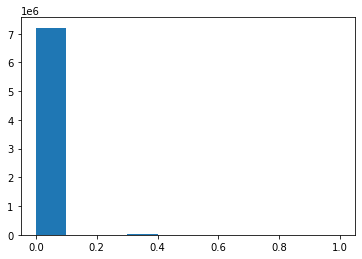

In [278]:
hist(np.ndarray.flatten(rbf_d))